In [64]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# EDA

In [66]:
# 1. LOAD DATASETS

train = pd.read_csv('C:/Users/somas/Documents/BigMart Sales Prediction/train_v9rqX0R.csv')
test_original = pd.read_csv('C:/Users/somas/Documents/BigMart Sales Prediction/test_AbJTz2l.csv')

# Copy test for transformations
test = test_original.copy()

In [68]:
train.info()
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


##### From this, we discovered:

##### Item_Weight and Outlet_Size contain missing values.
##### Item_Fat_Content has inconsistent labels (LF, low fat, reg).
##### Item_Visibility can be zero, which is likely missing in disguise.

In [70]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##### Item_Weight → 1463 missing
##### Outlet_Size → 2410 missing
##### We also checked the distribution of these columns:

##### Item_Weight had a fairly normal shape → chosen to fill with median.
##### Outlet_Size → replaced NaN with "Unknown" because it’s categorical.

In [72]:
test_original.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

##### Similarly, found missing in the same columns.

### Decision:

##### Median for Item_Weight.
##### Unknown for Outlet_Size.

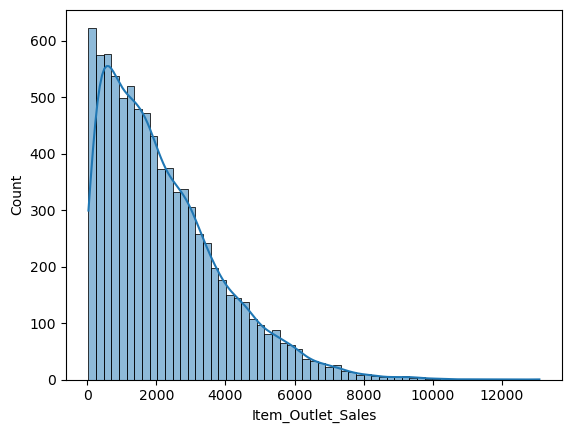

In [75]:
sns.histplot(train['Item_Outlet_Sales'], kde=True)
plt.show()

##### The distribution was right-skewed with some extremely large values → indicating potential outliers.
##### We decided to handle it later with a log transform.

##### Item_Visibility:

Zero values, which is not truly “0 visibility” but data-collection issues.
We replaced zeros with median per Item_Identifier.
Item_MRP:
Spans from 30 to 270. No major outliers since MRP is naturally capped.

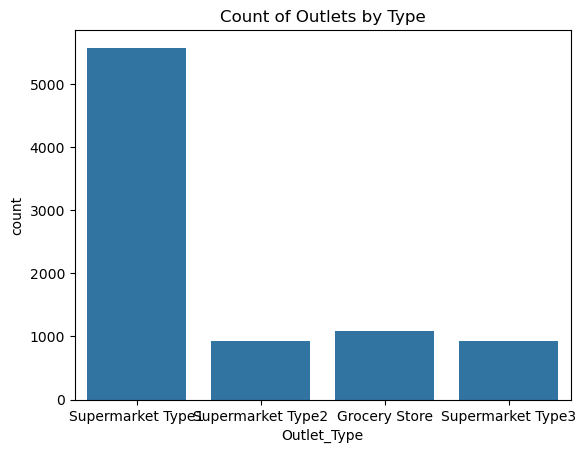

In [81]:
sns.countplot(x='Outlet_Type', data=train)
plt.title("Count of Outlets by Type")
plt.show()

#### Supermarket Type1 was the most frequent.

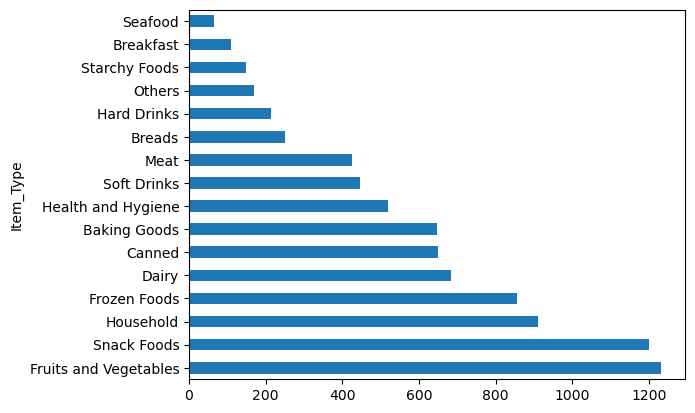

In [83]:
train['Item_Type'].value_counts().plot.barh()
plt.show()

##### “Fruits and Vegetables,” “Snack Foods,” “Household” are top categories.

In [41]:
# 2. DATA CLEANING
# Missing Item_Weight => median
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True)
test['Item_Weight'].fillna(test['Item_Weight'].median(), inplace=True)

# Missing Outlet_Size => 'Unknown'
train['Outlet_Size'].fillna('Unknown', inplace=True)
test['Outlet_Size'].fillna('Unknown', inplace=True)

# Standardize Item_Fat_Content
train['Item_Fat_Content'].replace({'low fat': 'Low Fat','LF': 'Low Fat','reg': 'Regular'}, inplace=True)
test['Item_Fat_Content'].replace({'low fat': 'Low Fat','LF': 'Low Fat','reg': 'Regular'}, inplace=True)

# Zero Item_Visibility => median by Item_Identifier
visibility_median = train.groupby('Item_Identifier')['Item_Visibility'].median()
train.loc[train['Item_Visibility'] == 0, 'Item_Visibility'] = \
    train['Item_Identifier'].map(visibility_median)
test.loc[test['Item_Visibility'] == 0, 'Item_Visibility'] = \
    test['Item_Identifier'].map(visibility_median)

C:\Users\somas\AppData\Local\Temp\ipykernel_33532\2653063707.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True)
C:\Users\somas\AppData\Local\Temp\ipykernel_33532\2653063707.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

### Imputations & Corrections
Item_Weight → median
Outlet_Size → "Unknown"
Item_Visibility → zero replaced by median grouped by Item_Identifier.
3.3 New Columns
Outlet_Age

2023 - Outlet_Establishment_Year
Hypothesis: older outlets may have higher footfall or stable sales.
Item–Outlet Aggregator Features

Item_Mean_Sales: mean of Item_Outlet_Sales for each Item_Identifier.
Outlet_Mean_Sales: mean of Item_Outlet_Sales for each Outlet_Identifier.
Merged them into train & test (filling missing merges in test with overall mean).
Why: Some items typically sell more, certain outlets typically yield higher sales. These aggregator features capture that directly.
Log Transform of target (Item_Outlet_Sales) → Log_Sales.

This addresses skew/outlier impact in sales.

In [43]:
# 3. FEATURE ENGINEERING

# Outlet Age
train['Outlet_Age'] = 2023 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2023 - test['Outlet_Establishment_Year']

train.drop('Outlet_Establishment_Year', axis=1, inplace=True)
test.drop('Outlet_Establishment_Year', axis=1, inplace=True)

# AGGREGATE FEATURES (ITEM & OUTLET) 
# Let's create 2 aggregator features from the training set:
#   (1) mean sales per Item_Identifier
#   (2) mean sales per Outlet_Identifier

item_mean_sales = train.groupby('Item_Identifier')['Item_Outlet_Sales'].mean().reset_index()
item_mean_sales.columns = ['Item_Identifier','Item_Mean_Sales']

outlet_mean_sales = train.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().reset_index()
outlet_mean_sales.columns = ['Outlet_Identifier','Outlet_Mean_Sales']

# Merge these aggregates into train
train = pd.merge(train, item_mean_sales, on='Item_Identifier', how='left')
train = pd.merge(train, outlet_mean_sales, on='Outlet_Identifier', how='left')

# We'll do the same merges for test
test = pd.merge(test, item_mean_sales, on='Item_Identifier', how='left')
test = pd.merge(test, outlet_mean_sales, on='Outlet_Identifier', how='left')

# NA might appear in test merges if an ID doesn't exist in train. Fill with global mean.
global_mean_sales = train['Item_Outlet_Sales'].mean()
test['Item_Mean_Sales'].fillna(global_mean_sales, inplace=True)
test['Outlet_Mean_Sales'].fillna(global_mean_sales, inplace=True)

C:\Users\somas\AppData\Local\Temp\ipykernel_33532\2506279261.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Item_Mean_Sales'].fillna(global_mean_sales, inplace=True)
C:\Users\somas\AppData\Local\Temp\ipykernel_33532\2506279261.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

#### We derived a new feature, Outlet_Age, by subtracting the establishment year from the current year (2023).
We then dropped the original Outlet_Establishment_Year, as it’s now redundant.
#### Why We Did It:
Direct Age: Knowing an outlet is, say, 30 years old vs. established in 1993 can be more intuitive for the model.
Comparative Consistency: A numeric “outlet age” might correlate with store reputation, loyal customer base, or wear-and-tear factors that affect sales.
Single Dimension: Replacing a year with age eliminates confusion about which baseline year to compare; the model sees a direct measure of how old each outlet is.

In [45]:
# 4. LABEL ENCODING

encoder = LabelEncoder()
categorical_cols = [
    'Item_Identifier', 'Item_Fat_Content', 'Item_Type',
    'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'
]

for col in categorical_cols:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])

#### Label Encoding (simple integer assignment).

In [47]:
# 5. LOG TRANSFORM THE TARGET

# Convert target to log-space to reduce outlier impact
train['Log_Sales'] = np.log1p(train['Item_Outlet_Sales'])

# 6. DEFINE FEATURES & TARGET

# We'll drop 'Item_Outlet_Sales' in favor of 'Log_Sales' for training
X = train.drop(columns=['Item_Outlet_Sales','Log_Sales'])
y = train['Log_Sales']   # log-transformed target

In [49]:
# 7. TRAIN-TEST SPLIT

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [51]:
# 8. SCALING NUMERIC FEATURES

scaler = StandardScaler()
num_cols = [
    'Item_Weight','Item_Visibility','Item_MRP','Outlet_Age',
    'Item_Mean_Sales','Outlet_Mean_Sales'  # newly added aggregator columns
]

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
test[num_cols]     = scaler.transform(test[num_cols])

#### We used StandardScaler on:

Item_Weight, Item_Visibility, Item_MRP, Outlet_Age, plus aggregator features Item_Mean_Sales & Outlet_Mean_Sales.
This helps advanced models (like RandomForest, CatBoost) handle numeric magnitude differences more gracefully.

In [53]:
# 9. RANDOM FOREST MODEL

rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=10, random_state=42
)

rf_model.fit(X_train, y_train)
rf_preds_log = rf_model.predict(X_valid)

# Evaluate with RMSE in normal space
rf_preds_normal = np.expm1(rf_preds_log)  # revert log->normal
y_valid_normal  = np.expm1(y_valid)

rf_rmse = np.sqrt(mean_squared_error(y_valid_normal, rf_preds_normal))
print(f'[Random Forest] RMSE: {rf_rmse:.4f}')

[Random Forest] RMSE: 1005.2302


In [54]:
# 10. TRAIN ON FULL DATA & PREDICT

rf_model.fit(X, y)
test_preds_log = rf_model.predict(test)
test_preds_normal = np.expm1(test_preds_log)

In [57]:
submission['Item_Outlet_Sales'] = test_preds_normal
display(submission.head(10))

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,99.678950
1,FDW14,OUT017,96.660457
2,NCN55,OUT010,74.599387
3,FDQ58,OUT017,93.832342
4,FDY38,OUT027,109.593872
5,FDH56,OUT046,105.395864
6,FDL48,OUT018,88.237783
7,FDC48,OUT027,112.139461
8,FDN33,OUT045,100.464615
9,FDA36,OUT017,102.486471


In [109]:
# 11. SUBMISSION

# Create submission with original IDs (test_original)
submission = test_original[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = test_preds_normal

project_dir = os.getcwd()
submission_file_path = os.path.join(project_dir, "RF_BigMartSalesPredictions.csv")

submission.to_csv(submission_file_path, index=False)
print(f'✅ Submission file saved at: {submission_file_path}')

✅ Submission file saved at: C:\Users\somas\Documents\BigMart Sales Prediction\RF_BigMartSalesPredictions.csv
